# Lrp loss

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')
from python.model_keras import BratsModel
from python.mask_utils import mask_value, get_mask_of_brain_rgb, get_mask_of_brain, get_mask_of_seg_rgb, get_mask_of_seg, mask_loss_val
from python.data_utils import LggHggGenerator
from python.visualization import plot_rgb, plot_gray, plot_lrp
from python import plots

In [2]:
import math
from tensorflow import keras
import innvestigate
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import load_model

In [3]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

## Data loading

In [4]:
batch_size = 32
epochs = 50
IMG_HEIGHT = 240
IMG_WIDTH = 240

In [5]:
train_dir = '../data/train/confidence_19/'
seg_train_dir = '../data/train/seg_confidence_19/'
val_dir = '../data/valid/confidence_19/'
seg_val_dir = '../data/valid/seg_confidence_19/'

train_image_generator = ImageDataGenerator(rescale=1./255, 
                                           rotation_range=45,
                                           horizontal_flip=True,
                                           vertical_flip=True)
train_seg_generator = ImageDataGenerator(rotation_range=45,
                                           horizontal_flip=True,
                                           vertical_flip=True)
val_image_generator = ImageDataGenerator(rescale=1./255)
val_seg_generator = ImageDataGenerator()

lgg_hgg_generator = LggHggGenerator(train_image_generator, train_seg_generator, train_dir, seg_train_dir)
val_lgg_hgg_generator = LggHggGenerator(val_image_generator, val_seg_generator, val_dir, seg_val_dir)

In [6]:
train_image_gen = lgg_hgg_generator.get_image_generator(batch_size)
train_seg_gen = lgg_hgg_generator.get_seg_generator(batch_size)
val_image_gen = val_lgg_hgg_generator.get_image_generator(batch_size)
val_seg_gen = val_lgg_hgg_generator.get_seg_generator(batch_size)

Found 1645 images belonging to 2 classes.
Found 1645 images belonging to 2 classes.
Found 446 images belonging to 2 classes.
Found 446 images belonging to 2 classes.


### Visualization

In [7]:
x, y = next(train_image_gen)
x_seg, y_seg = next(train_seg_gen)

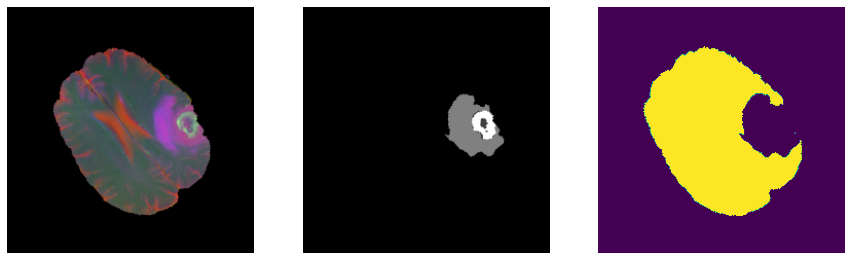

In [8]:
i = 11
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes = axes.flatten()
plot_rgb(x[i], ax= axes[0])
plot_gray(x_seg[i], ax= axes[1])
plot_rgb(get_mask_of_brain(x[i], get_mask_of_seg(x_seg[i]).squeeze()), ax= axes[2])

## Model definition

In [9]:
y = keras.layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH ,3), name='input_layer')
x = keras.layers.Conv2D(16, 3, padding='same', activation='relu', name='conv_a')(y)
x = keras.layers.MaxPooling2D(name='max_a')(x)
x = keras.layers.Dropout(0.2,name='drop_a')(x)
x = keras.layers.Conv2D(32, 3, padding='same', activation='relu', name='conv_b')(x)
x = keras.layers.MaxPooling2D(name='max_b')(x)
x = keras.layers.Conv2D(64, 3, padding='same', activation='relu', name='conv_c')(x)
x = keras.layers.MaxPooling2D(name='max_c')(x)
x = keras.layers.Conv2D(128, 3, padding='same', activation='relu', name='conv_d')(x)
x = keras.layers.MaxPooling2D(name='max_d')(x)
x = keras.layers.Dropout(0.2, name='drop_c')(x)
x = keras.layers.Flatten(name='flat_a')(x)
x = keras.layers.Dense(64, activation='relu', name='dense_a')(x)
x = keras.layers.Dense(2, name='dense_b')(x)
model = keras.Model(y, x)

## Model training

In [10]:
optimizer = keras.optimizers.Adam()

def get_analysis(x, analyzer, labels):
    return np.array([t[int(l)] for l, t in zip(labels, zip(
            analyzer.analyze(x, neuron_selection = 0)['input_layer'],
            analyzer.analyze(x, neuron_selection = 1)['input_layer']
        ))])
#     a1 = analyzer.analyze(x, neuron_selection = 0)['input_layer']
#     a2 = analyzer.analyze(x, neuron_selection = 1)['input_layer']
#     return analyzer.analyze(x)['input_layer']


def get_lrp_loss(model):
    analyzer = innvestigate.create_analyzer("lrp.epsilon", model, epsilon=1)
    loss_function = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    def loss(target_y, predicted_y, x, x_seg):
        loss_value =  loss_function(target_y, predicted_y)
        mask_value = mask_loss_val(x, get_analysis(x, analyzer, target_y), x_seg)
        return loss_value / tf.pow(mask_value, 2), mask_value
    return loss


def step(xs, xs_seg, ys, loss_function):  # This has the same meaning as step function in previous labs
    
    with tf.GradientTape() as tape:
        preds = model(xs)  # Model predictions
        loss, mask = loss_function(ys, preds, xs, xs_seg)  # The value of loss function comparing the true
                                         # values ys with predictions
    
    gradient = tape.gradient(
        target=loss,
        sources=model.trainable_variables)  # Calculate the gradient of loss function w.r.t. model parameters.
                                            # This behaves the same as gradient methods from previous labs.
        
    optimizer.apply_gradients(zip(gradient, model.trainable_variables))  # Applies the computed gradient on current
    return loss, mask                                                                     # parameter values.    

In [11]:
def get_val_stat(gen, gen_seg, loss_function, model):
    num_batches = math.ceil(gen.samples / batch_size)
    y_true_v = []
    pred_v = []
    l = []
    v = []
    for i, ((images, labels), (images_seg, _)) in enumerate(zip(gen, gen_seg)):
        if i >= num_batches:
            break
        prob = model.predict(images)
        p = prob.argmax(axis=1)
        pred_v.extend(p)
        y_true_v.extend(labels)
        loss, mask = loss_function(labels, prob, images, images_seg)
        v.append(mask)
        l.append(loss)
    return np.mean(l), np.mean(v), pred_v, y_true_v

In [12]:
loss_function = get_lrp_loss(model)
num_batches = math.ceil(train_image_gen.samples / batch_size)
# Training loop (without shuffling for simplicity)
for e in range(epochs):
    v = []
    l = []
    for i, ((images, labels), (images_seg, _)) in enumerate(zip(train_image_gen, train_seg_gen)):
        if i >= 4:
            break
        loss, mask = step(images, images_seg, labels, loss_function)
        v.append(mask)
        l.append(loss)
        
    pred = model(images)
    l_val, m_val, _, _ = get_val_stat(val_image_gen, val_seg_gen, loss_function, model)
    print('Epoch:', e, 'Train loss:', np.mean(l), 'Train mask:', np.mean(v),
         'Test loss:', l_val, 'Test mask:', m_val)

Epoch: 0 Train loss: 3.7799752 Train mask: 0.44097418 Test loss: 2.6287224 Test mask: 0.52246135
Epoch: 1 Train loss: 2.5694642 Train mask: 0.5190674 Test loss: 1.8858 Test mask: 0.6212202
Epoch: 2 Train loss: 2.6134434 Train mask: 0.5229503 Test loss: 2.8193142 Test mask: 0.49360722
Epoch: 3 Train loss: 3.9970691 Train mask: 0.4279039 Test loss: 1.8508685 Test mask: 0.60851806
Epoch: 4 Train loss: 1.8222848 Train mask: 0.60667765 Test loss: 1.2789185 Test mask: 0.750138
Epoch: 5 Train loss: 1.6797808 Train mask: 0.62506413 Test loss: 1.5415059 Test mask: 0.66880566
Epoch: 6 Train loss: 4.4521565 Train mask: 0.4371265 Test loss: 1.8976911 Test mask: 0.57334787
Epoch: 7 Train loss: 2.0320673 Train mask: 0.56255615 Test loss: 1.3850911 Test mask: 0.71128124
Epoch: 8 Train loss: 1.943858 Train mask: 0.6048311 Test loss: 1.687596 Test mask: 0.61064845
Epoch: 9 Train loss: 3.5590959 Train mask: 0.43962196 Test loss: 2.341441 Test mask: 0.5184788
Epoch: 10 Train loss: 4.7473545 Train mask: 0

ValueError: ('Xs has not supported type ', <class 'numpy.ndarray'>)

## Evaluation

In [13]:
images, y = next(val_image_gen)
images_seg, y_seg = next(val_seg_gen)

In [7]:
model = load_model('../models/brats19_4.h5')

In [14]:
analyzer = innvestigate.create_analyzer("lrp.epsilon", model, epsilon=1)

In [15]:
analysis = analyzer.analyze(images)['input_layer']

Mask Value:  0.7601336
Label:  0.0


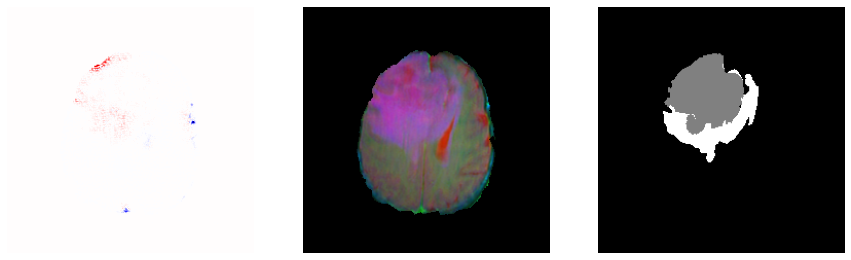

In [16]:
def postprocess_lrp(analyzed_image):
    analyzed_image = analyzed_image.sum(axis=np.argmax(np.asarray(analyzed_image.shape) == 3))
    analyzed_image /= np.max(np.abs(analyzed_image))
    return analyzed_image

label = 3
print("Mask Value: ", mask_value(analysis[label], images[label], get_mask_of_seg_rgb(images_seg[label])))
print("Label: ", y[label])
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes = axes.flatten()
plot_lrp(postprocess_lrp(analysis[label]), ax=axes[0])
plot_rgb(images[label], ax=axes[1])
plot_gray(images_seg[label], ax=axes[2])

Label:  1.0


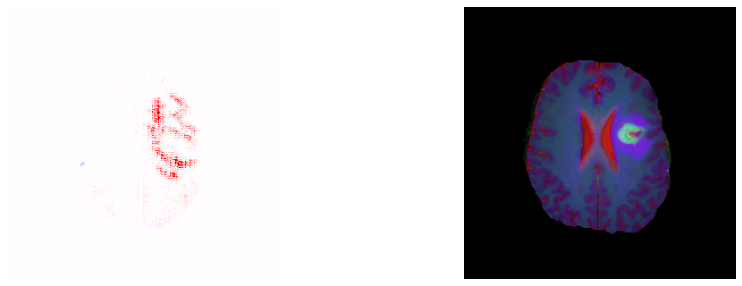

In [19]:
def postprocess_lrp(analyzed_image):
    analyzed_image = analyzed_image.sum(axis=np.argmax(np.asarray(analyzed_image.shape) == 3))
    analyzed_image /= np.max(np.abs(analyzed_image))
    return analyzed_image

label = 2
print("Label: ", y[label])
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes = axes.flatten()
plot_lrp(postprocess_lrp(analysis[label]), ax=axes[0])
plot_rgb(images[label], ax=axes[1])

In [15]:
def get_mask_stat(gen, gen_seg, model):
    analyzer = innvestigate.create_analyzer("lrp.epsilon", model, epsilon=1)
    num_batches = math.ceil(gen.samples / batch_size)
    labels = []
    pred = []
    mask_values = []
    for i, ((images, y), (images_seg, _)) in enumerate(zip(gen, gen_seg)):
        if i >= num_batches:
            break
        prob = model.predict(images)
        analysis = analyzer.analyze(images)["input_layer"]
        mask = [
            mask_value(i_a, i, get_mask_of_seg_rgb(i_s))
            for i, i_a, i_s in zip(images, analysis, images_seg)
        ]
        p = prob.argmax(axis=1)
        pred.extend(p)
        labels.extend(y)
        mask_values.extend(mask)
    return np.array(mask_values), np.array(pred), np.array(labels)

In [16]:
m, p, y = get_mask_stat(val_image_gen, val_seg_gen, model)

In [17]:
np.mean(m[y==0])

0.4151822

In [18]:
np.mean(m[y==1])

0.34345734

Model performance:
              precision    recall  f1-score   support

         0.0       0.57      0.61      0.59       186
         1.0       0.71      0.68      0.69       260

    accuracy                           0.65       446
   macro avg       0.64      0.64      0.64       446
weighted avg       0.65      0.65      0.65       446



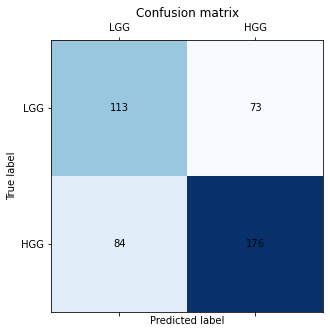

In [17]:
y_true_v = []
pred_v = []
iterations = 428 / batch_size
for i, (images, labels) in enumerate(val_image_gen):
    if i > iterations:
        break
    prob = model.predict(images)
    p = prob.argmax(axis=1)
    pred_v.extend(p)
    y_true_v.extend(labels)
plots.plot_model_performance(y_true_v, pred_v)

In [17]:
y_true_t = []
pred_t = []
iterations = 428 / batch_size
for i, (images, labels) in enumerate(test_data_gen):
    if i > iterations:
        break
    prob = model.predict(images)
    p = prob.argmax(axis=1)
    pred_t.extend(p)
    y_true_t.extend(labels)
plots.plot_model_performance(y_true_t, pred_t)

NameError: name 'test_data_gen' is not defined

In [1]:
!pip install --use-feature=2020-resolver "git+https://github.com/albermax/innvestigate.git@updates_towards_tf2.0"

  Cloning https://github.com/albermax/innvestigate.git (to revision updates_towards_tf2.0) to /tmp/pip-req-build-fk86n6z2
     |████████████████████████████████| 829 kB 3.2 MB/s eta 0:00:01
     |████████████████████████████████| 421.8 MB 10.6 MB/s eta 0:00:01     |██████████████▊                 | 193.5 MB 12.2 MB/s eta 0:00:19     |██████████████████▍             | 242.3 MB 12.2 MB/s eta 0:00:15
     |████████████████████████████████| 50 kB 6.3 MB/s  eta 0:00:01
     |████████████████████████████████| 3.8 MB 12.3 MB/s eta 0:00:01


     |████████████████████████████████| 448 kB 11.8 MB/s eta 0:00:01
  Created wheel for innvestigate: filename=innvestigate-2.0.0-py3-none-any.whl size=107093 sha256=46cdc60782966dc136cd6d46803238d4263e3de9a59220cf97952d5fbd52c15a
  Stored in directory: /tmp/pip-ephem-wheel-cache-hsi4557z/wheels/5c/25/10/76772cf76d6eb4346d31e1f6e32bce55ee94d9e7c6c98d1a3f
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=493275 sha256=20267ff0aba05e512631adf4bd28f2530965d7b22b11f45b3d0f9645d388b297
  Stored in directory: /root/.cache/pip/wheels/6e/9c/ed/4499c9865ac1002697793e0ae05ba6be33553d098f3347fb94
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7635 sha256=1b3fb5557a3d9298dc32f50a1e34a027cbdb0c3797a16d9637ecb4a201cb1d07
  Stored in directory: /root/.cache/pip/wheels/19/a7/b9/0740c7a3a7d1d348f04823339274b90de25fbcd217b2ee1fbe
Successfully built innvestigate future gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflo